In [182]:
import pandas as pd

file = "data/BASE DE DATOS PCC_cleaned.xlsx"
df_char = pd.read_excel(file)

In [214]:
from sklearn.discriminant_analysis import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder


def preparar_datos(df, features, target_col, test_size=0.2, random_state=0, scale_num_only=True):
    df_modelo = df[(df['estado'] == 'play') & (df[target_col].notna())].copy()

    cat_features = [col for col, tipo in features.items() if tipo == 'categorica']
    num_features = [col for col, tipo in features.items() if tipo == 'numerica']

    X = df_modelo[list(features.keys())].copy()
    y = df_modelo[target_col]

    encoder = OrdinalEncoder()
    X[cat_features] = encoder.fit_transform(X[cat_features])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    if scale_num_only:
        scaler = StandardScaler()
        X_train[num_features] = scaler.fit_transform(X_train[num_features])
        X_test[num_features] = scaler.transform(X_test[num_features])
    else:
        scaler = None

    return X_train, X_test, y_train, y_test, encoder, scaler


1. Fabricadas totales dadas (solo se considerarán los datos que se tienen cuando la máquina está en play):
    - Tipo de proceso.
    - Sección
    - Turno
    - Maquina
    - Usuario

In [211]:
features = {
    'referencia': 'categorica',
    'maquina': 'categorica',
    'seccion': 'categorica',
    'proceso': 'categorica',
    'usuario': 'categorica',
    'duracion_min': 'numerica',
    'hora_inicio': 'numerica',
    'dia_semana_inicio': 'categorica',
    'turno': 'categorica'
}
# Preparar los datos
#Filtro para incluir solo las filas con 'estado' == 'play'
df_play = df_char[df_char['estado'] == 'play']
X_train, X_test, y_train, y_test, encoder, scaler = preparar_datos(df_play, features, target_col='fabricadas')


*Seleccción de variables*

In [185]:
#Lasso
from sklearn.linear_model import LassoCV

lasso = LassoCV(cv=5, random_state=0)
lasso.fit(X_train, y_train)

#Coeficientes
coef_df = pd.Series(lasso.coef_, index=features)
print("Coeficientes Lasso:")
print(coef_df)

#Variables seleccionadas
selected_features = coef_df[coef_df != 0].index.tolist()
print("\nVariables seleccionadas por Lasso:")
print(selected_features)

#Desempeño
print("\nR² en test:", lasso.score(X_test, y_test))

Coeficientes Lasso:
referencia            2362.657031
maquina               3915.661871
seccion              -1490.680325
proceso              -4406.901672
usuario                686.646687
duracion_min         14561.706143
hora_inicio           -391.053359
dia_semana_inicio      599.896162
turno                   -0.000000
dtype: float64

Variables seleccionadas por Lasso:
['referencia', 'maquina', 'seccion', 'proceso', 'usuario', 'duracion_min', 'hora_inicio', 'dia_semana_inicio']

R² en test: 0.28793946585092667


In [212]:
#Seleccion de variables por significancia estadística

import statsmodels.api as sm

# Convert X_train (numpy array) to DataFrame with correct column names
X_train_ols = pd.DataFrame(X_train, columns=list(features.keys()))

# Ajustar el modelo OLS asegurando que los índices estén alineados
model = sm.OLS(y_train.reset_index(drop=True), X_train_ols)

result = model.fit()

# Resumen del modelo
result.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:             fabricadas   R-squared (uncentered):                   0.141
Model:                            OLS   Adj. R-squared (uncentered):              0.140
Method:                 Least Squares   F-statistic:                              123.6
Date:               dom, 01 jun. 2025   Prob (F-statistic):                   4.74e-216
Time:                        17:52:21   Log-Likelihood:                         -80824.
No. Observations:                6768   AIC:                                  1.617e+05
Df Residuals:                    6759   BIC:                                  1.617e+05
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
referencia         2425.0964    459.930      5.273      0.000    1523.489    3326.703
maquina            4063.8519    678.414      5.990      0.000    2733.947    5393.757
seccion           -1621.8513    797.603     -2.033      0.042   -3185.405     -58.298
proceso           -4360.6872    813.205     -5.362      0.000   -5954.824   -2766.550
usuario             753.1310    456.073      1.651      0.099    -140.916    1647.178
duracion_min       1.464e+04    478.218     30.608      0.000    1.37e+04    1.56e+04
hora_inicio        -439.7984    535.976     -0.821      0.412   -1490.481     610.884
dia_semana_inicio   662.4428    452.414      1.464      0.143    -224.431    1549.316
turno               -29.2347    532.759     -0.055      0.956   -1073.609    1015.140
==============================================================================
Omnibus:                     2071.821   Durbin-Watson:                   0.885
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6537.720
Skew:                           1.568   Prob(JB):                         0.00
Kurtosis:                       6.654   Cond. No.                         3.53
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [213]:
#Valores p> 0.05
p_values = result.pvalues[result.pvalues > 0.05]
#Caracteristicas con p > 0.05
non_significant_features = p_values.index.tolist()
print("\nVariables no significativas (p > 0.05):")
print(non_significant_features)
# Variables significativas
significant_features = [feature for feature in features.keys() if feature not in non_significant_features]
print("\nVariables significativas:")
print(significant_features)


Variables no significativas (p > 0.05):
['usuario', 'hora_inicio', 'dia_semana_inicio', 'turno']

Variables significativas:
['referencia', 'maquina', 'seccion', 'proceso', 'duracion_min']


In [188]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

models = {
    'LinearRegression': {
        'model': LinearRegression(),
        'params': {}
    },
    'Lasso': {
        'model': Lasso(),
        'params': {
            'alpha': [0.001, 0.01, 0.1, 1.0, 10.0]
        }
    },
    'Ridge': {
        'model': Ridge(),
        'params': {
            'alpha': [0.01, 0.1, 1.0, 10.0, 100.0]
        }
    },
    'RandomForest': {
        'model': RandomForestRegressor(random_state=42),
        'params': {
            'n_estimators': [50, 100],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5]
        }
    },
    'GradientBoosting': {
        'model': GradientBoostingRegressor(random_state=42),
        'params': {
            'n_estimators': [50, 100],
            'learning_rate': [0.05, 0.1],
            'max_depth': [3, 5]
        }
    },
    'KNN': {
        'model': KNeighborsRegressor(),
        'params': {
            'n_neighbors': [1,3, 5, 7, 9, 11,15,20,25,30,35,40],
            'weights': ['uniform', 'distance'],
            'p': [1, 2]  # 1 = Manhattan, 2 = Euclidean
        }
    },
    # "MLPRegressor": {
    #     "model": MLPRegressor(max_iter=1000, random_state=42),
    #     "params": {
    #         "hidden_layer_sizes": [(50,), (100,), (100, 50)],
    #         "activation": ["relu", "tanh"],
    #         "solver": ["adam"],
    #         "alpha": [0.0001, 0.001],
    #         "learning_rate": ["constant", "adaptive"]
    #     }
    # }
}


In [189]:
from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error
import time
import pandas as pd

def evaluar_modelos(models, X_train, y_train, scoring="neg_root_mean_squared_error", cv=5):
    tuned_results = {}
    all_grid_results = []

    for name, config in models.items():
        print(f"Evaluando: {name}")
        start_time = time.time()

        # Configuración de GridSearchCV
        grid = GridSearchCV(
            estimator=config["model"],
            param_grid=config["params"],
            cv=cv,
            scoring=scoring,
            n_jobs=-1
        )

        # Entrenamiento
        grid.fit(X_train, y_train)
        best_model = grid.best_estimator_
        training_time = time.time() - start_time

        # Predicción con validación cruzada (para métricas generalizables)
        y_pred = cross_val_predict(best_model, X_train, y_train, cv=cv)

        # Métricas
        result_metrics = {
            "Model": best_model,
            "Best Params": grid.best_params_,
            "RMSE": root_mean_squared_error(y_train, y_pred),
            "MAE": mean_absolute_error(y_train, y_pred),
            "R2 Score": r2_score(y_train, y_pred),
            "Training Time (s)": training_time
        }

        tuned_results[name] = result_metrics

        print(result_metrics)
        print("\n" + "="*50 + "\n")

        # Guardar todos los resultados del grid
        grid_df = pd.DataFrame(grid.cv_results_)
        grid_df["Model"] = name
        all_grid_results.append(grid_df)

    # Consolidar resultados
    tuned_metrics = pd.DataFrame({
        name: {k: v for k, v in res.items() if k != "Model"} for name, res in tuned_results.items()
    }).T

    return tuned_results, tuned_metrics, pd.concat(all_grid_results, ignore_index=True)

In [216]:

# Selected variables for training
selected_features = {feature: tipo for feature, tipo in features.items() if feature in significant_features}

x_train_selected, x_test_selected, y_train_selected, y_test_selected, encoder_selected, scaler_selected = preparar_datos(
    df_play, selected_features, target_col='fabricadas'
)


In [217]:
# Entrenamiento y evaluación de modelos
tuned_results, tuned_metrics, grid_results = evaluar_modelos(models, x_train_selected, y_train_selected)
tuned_metrics = tuned_metrics.sort_values(by='RMSE')
tuned_metrics

Evaluando: LinearRegression
{'Model': LinearRegression(), 'Best Params': {}, 'RMSE': 25054.20483747346, 'MAE': 17785.165853515176, 'R2 Score': 0.2644819484552753, 'Training Time (s)': 0.03345203399658203}


Evaluando: Lasso
{'Model': Lasso(), 'Best Params': {'alpha': 1.0}, 'RMSE': 25054.20408497988, 'MAE': 17785.05160441832, 'R2 Score': 0.26448199263728833, 'Training Time (s)': 0.0805501937866211}


Evaluando: Ridge
{'Model': Ridge(), 'Best Params': {'alpha': 1.0}, 'RMSE': 25054.203668809314, 'MAE': 17785.193865206096, 'R2 Score': 0.2644820170723844, 'Training Time (s)': 0.06856226921081543}


Evaluando: RandomForest
{'Model': RandomForestRegressor(max_depth=20, min_samples_split=5, random_state=42), 'Best Params': {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 100}, 'RMSE': 20974.380023675865, 'MAE': 13865.672653228596, 'R2 Score': 0.4845217406770357, 'Training Time (s)': 8.36345887184143}


Evaluando: GradientBoosting
{'Model': GradientBoostingRegressor(max_depth=5, random

,Best Params,RMSE,MAE,R2 Score,Training Time (s)
GradientBoosting,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",19356.289653,12854.566879,0.560988,3.103994
KNN,"{'n_neighbors': 7, 'p': 1, 'weights': 'distance'}",20337.643236,12576.114493,0.515344,0.620579
RandomForest,"{'max_depth': 20, 'min_samples_split': 5, 'n_e...",20974.380024,13865.672653,0.484522,8.363459
Ridge,{'alpha': 1.0},25054.203669,17785.193865,0.264482,0.068562
Lasso,{'alpha': 1.0},25054.204085,17785.051604,0.264482,0.08055
LinearRegression,{},25054.204837,17785.165854,0.264482,0.033452


In [192]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
def graficar_rmse_modelos(all_grid_results):
    """
    Grafica la distribución de RMSE (conversión de neg_root_mean_squared_error) para modelos de regresión,
    anotando los mejores y peores resultados por modelo.

    Parámetros:
    - all_grid_results: lista de pd.DataFrame
        Cada DataFrame debe ser el resultado de grid.cv_results_ con una columna 'Model' indicando el nombre.

    Retorna:
    - cv_scores_df: pd.DataFrame concatenado con columna 'rmse' (positiva)
    """

    # Concatenar todos los resultados en un solo DataFrame
    cv_scores_df = pd.concat(all_grid_results, ignore_index=True)

    # Convertir la métrica negativa a positiva para RMSE
    cv_scores_df['rmse'] = -cv_scores_df['mean_test_score']

    # Graficar
    plt.figure(figsize=(12, 6))
    sns.stripplot(data=cv_scores_df, x='rmse', y='Model', jitter=True, alpha=0.5)
    plt.xlabel("RMSE (Cross-Validation)")
    plt.title("Distribución de RMSE por Modelo")

    # Anotar los mejores y peores hiperparámetros para cada modelo
    for modelo in cv_scores_df['Model'].unique():
        # Si algún modelo no tiene hiperparámetros, se puede omitir (ej: LinearRegression)
        df_modelo = cv_scores_df[cv_scores_df['Model'] == modelo]

        # Mejor RMSE es el mínimo
        idx_best = df_modelo['rmse'].idxmin()
        idx_worst = df_modelo['rmse'].idxmax()
        best_row = df_modelo.loc[idx_best]
        worst_row = df_modelo.loc[idx_worst]

        # Anotar mejor
        plt.annotate(
            f"Best: {best_row['params']}",
            xy=(best_row['rmse'], modelo),
            textcoords='offset points',
            xytext=(0, 15),
            ha='center',
            fontsize=7,
            color='green',
            arrowprops=dict(arrowstyle='->', color='green', lw=0.8)
        )

        # Anotar peor
        plt.annotate(
            f"Worst: {worst_row['params']}",
            xy=(worst_row['rmse'], modelo),
            textcoords='offset points',
            xytext=(0, -20),
            ha='center',
            fontsize=7,
            color='red',
            arrowprops=dict(arrowstyle='->', color='red', lw=0.8)
        )

    plt.tight_layout()
    plt.show()

    return cv_scores_df

    """
    Grafica la distribución de una métrica por modelo con anotaciones de mejores y peores parámetros.

    Parámetros:
    - all_grid_results: lista de DataFrames con resultados de GridSearchCV.
    - metrica: str, nombre de la métrica a graficar (debe estar en mean_test_score o equivalente).
    - maximize: bool, si True la métrica se maximiza (ej. ROC AUC), si False se minimiza (ej. RMSE).
    
    Retorna:
    - cv_scores_df: DataFrame concatenado con la métrica calculada.
    """
    cv_scores_df = pd.concat(all_grid_results, ignore_index=True)

    # Si es RMSE u otra métrica negativa, convertir a positivo
    if not maximize:
        cv_scores_df[metrica] = -cv_scores_df["mean_test_score"]
    else:
        cv_scores_df[metrica] = cv_scores_df["mean_test_score"]

    plt.figure(figsize=(12, 6))
    sns.stripplot(data=cv_scores_df, x=metrica, y="Model", jitter=True, alpha=0.5)
    plt.xlabel(f"{metrica.upper()} (Cross-Validation)")
    plt.title(f"Distribución de {metrica.upper()} por Modelo")

    for model in cv_scores_df["Model"].unique():
        df_model = cv_scores_df[cv_scores_df["Model"] == model]

        if maximize:
            best_idx = df_model[metrica].idxmax()
            worst_idx = df_model[metrica].idxmin()
        else:
            best_idx = df_model[metrica].idxmin()
            worst_idx = df_model[metrica].idxmax()

        best_row = df_model.loc[best_idx]
        worst_row = df_model.loc[worst_idx]

        plt.annotate(
            f"Best: {best_row['params']}",
            xy=(best_row[metrica], model),
            textcoords='offset points',
            xytext=(0, 15),
            ha='center',
            fontsize=7,
            color='green',
            arrowprops=dict(arrowstyle="->", color='green', lw=0.8)
        )
        plt.annotate(
            f"Worst: {worst_row['params']}",
            xy=(worst_row[metrica], model),
            textcoords='offset points',
            xytext=(0, -20),
            ha='center',
            fontsize=7,
            color='red',
            arrowprops=dict(arrowstyle="->", color='red', lw=0.8)
        )

    plt.tight_layout()
    plt.show()

    return cv_scores_df
def graficar_mejor_rmse_por_modelo(all_grid_results):
    """
    Grafica el mejor RMSE (mínimo) obtenido por cada modelo en los resultados de GridSearchCV.

    Parámetros:
    - all_grid_results: lista de pd.DataFrame
        Lista con resultados de validación cruzada (grid.cv_results_ + columna 'Model').

    Retorna:
    - best_rmse_df: pd.DataFrame con el mejor RMSE por modelo.
    """

    # Concatenar resultados
    cv_scores_df = pd.concat(all_grid_results, ignore_index=True)

    # Corregir RMSE porque mean_test_score viene negativo en sklearn para RMSE
    cv_scores_df['rmse'] = -cv_scores_df['mean_test_score']

    # Obtener índice del mejor RMSE (mínimo) por modelo
    idx_best = cv_scores_df.groupby('Model')['rmse'].idxmin()

    # Extraer mejores filas
    best_rmse_df = cv_scores_df.loc[idx_best].copy()

    # Graficar
    plt.figure(figsize=(10, 6))
    sns.barplot(data=best_rmse_df, x='rmse', y='Model', palette='viridis')
    plt.xlabel("Mejor RMSE (CV)")
    plt.ylabel("Modelo")
    plt.title("Mejor RMSE por Modelo")
    plt.tight_layout()
    plt.show()

    return best_rmse_df

    """
    Grafica una barra con el mejor resultado por modelo para la métrica dada.

    Parámetros:
    - all_grid_results: lista de DataFrames con resultados de GridSearchCV.
    - metrica: str, nombre de la métrica a graficar.
    - maximize: bool, si True la métrica se maximiza, si False se minimiza.

    Retorna:
    - best_metric_df: DataFrame con el mejor resultado por modelo.
    """
    cv_scores_df = pd.concat(all_grid_results, ignore_index=True)

    if not maximize:
        cv_scores_df[metrica] = -cv_scores_df["mean_test_score"]
        best_metric_df = cv_scores_df.loc[cv_scores_df.groupby("Model")[metrica].idxmin()]
    else:
        cv_scores_df[metrica] = cv_scores_df["mean_test_score"]
        best_metric_df = cv_scores_df.loc[cv_scores_df.groupby("Model")[metrica].idxmax()]

    plt.figure(figsize=(10, 6))
    sns.barplot(data=best_metric_df, x=metrica, y="Model", palette="viridis")
    plt.xlabel(f"Mejor {metrica.upper()} (Cross-Validation)")
    plt.ylabel("Modelo")
    plt.title(f"Mejor {metrica.upper()} por Modelo")
    plt.tight_layout()
    plt.show()

    return best_metric_df


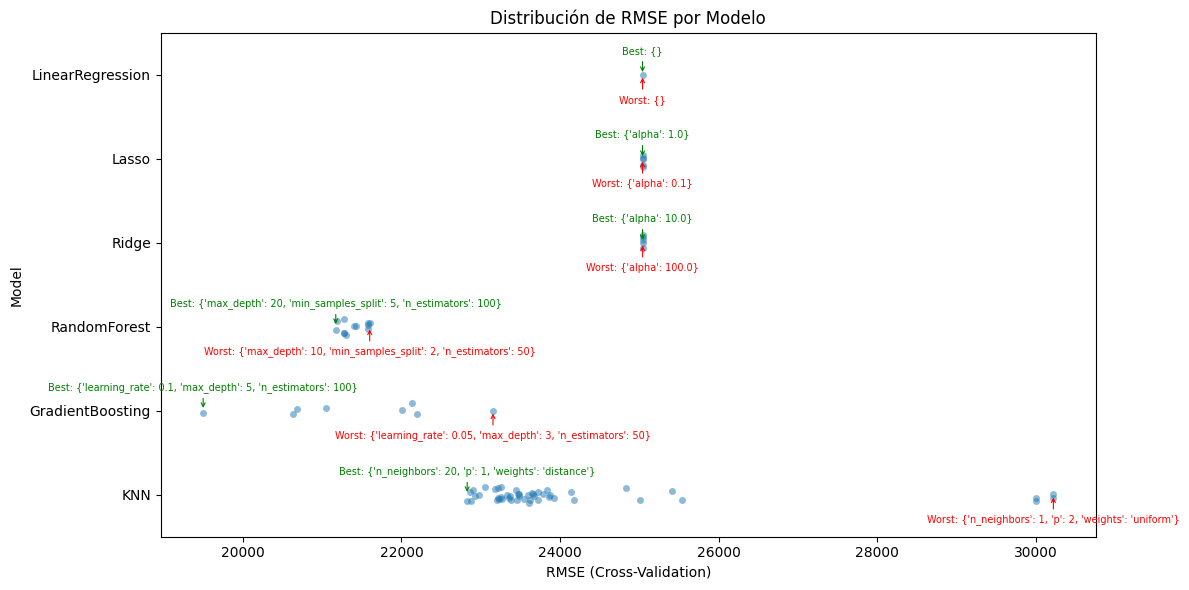

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,...,Model,param_alpha,param_max_depth,param_min_samples_split,param_n_estimators,param_learning_rate,param_n_neighbors,param_p,param_weights,rmse
0,0.003404,0.000489,0.001400,0.000488,{},-25183.772072,-24086.410529,-24743.807284,-25464.384073,-25719.110377,...,LinearRegression,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25039.496867
1,0.006001,0.000005,0.001799,0.000749,{'alpha': 0.001},-25183.772060,-24086.410599,-24743.807265,-25464.384114,-25719.110306,...,Lasso,0.001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25039.496869
2,0.006203,0.000397,0.001800,0.001165,{'alpha': 0.01},-25183.771995,-24086.411216,-24743.807196,-25464.384525,-25719.109698,...,Lasso,0.010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25039.496926
3,0.005001,0.000634,0.001904,0.000665,{'alpha': 0.1},-25183.771768,-24086.417325,-24743.805445,-25464.388022,-25719.103179,...,Lasso,0.100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25039.497148
4,0.005200,0.000748,0.002400,0.000489,{'alpha': 1.0},-25183.723871,-24086.474860,-24743.814958,-25464.412546,-25719.051914,...,Lasso,1.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25039.495630
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,0.009904,0.001624,0.052274,0.006964,"{'n_neighbors': 35, 'p': 2, 'weights': 'distan...",-23384.718480,-22282.772924,-23254.251775,-23457.429726,-23788.255744,...,KNN,NaN,NaN,NaN,NaN,NaN,35.0,2.0,distance,23233.485730
75,0.009998,0.001093,0.065020,0.001607,"{'n_neighbors': 40, 'p': 1, 'weights': 'uniform'}",-23793.147564,-22521.707493,-23631.462123,-23700.687939,-24068.419487,...,KNN,NaN,NaN,NaN,NaN,NaN,40.0,1.0,uniform,23543.084921
76,0.010562,0.001932,0.069320,0.005050,"{'n_neighbors': 40, 'p': 1, 'weights': 'distan...",-23249.726277,-21955.866700,-23135.164349,-23118.715205,-23402.460891,...,KNN,NaN,NaN,NaN,NaN,NaN,40.0,1.0,distance,22972.386684
77,0.009903,0.000808,0.050624,0.005030,"{'n_neighbors': 40, 'p': 2, 'weights': 'uniform'}",-23852.192766,-22639.179568,-23711.916921,-24072.429278,-24311.228018,...,KNN,NaN,NaN,NaN,NaN,NaN,40.0,2.0,uniform,23717.389310


In [193]:
graficar_rmse_modelos([grid_results])


C:\Users\yosse\AppData\Local\Temp\ipykernel_8456\1614309977.py:157: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=best_rmse_df, x='rmse', y='Model', palette='viridis')


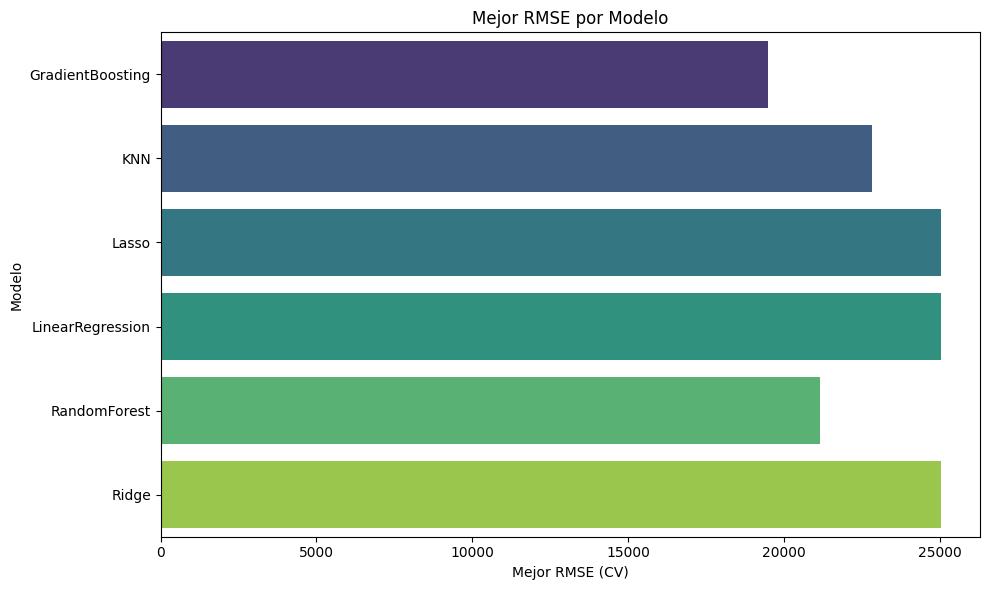

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,...,Model,param_alpha,param_max_depth,param_min_samples_split,param_n_estimators,param_learning_rate,param_n_neighbors,param_p,param_weights,rmse
30,0.900754,0.015411,0.003802,0.000403,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",-19812.191799,-18457.002855,-19388.636075,-19818.018571,-20029.659456,...,GradientBoosting,NaN,5,NaN,100.0,0.1,NaN,NaN,NaN,19501.101751
60,0.009999,0.001097,0.050210,0.003074,"{'n_neighbors': 20, 'p': 1, 'weights': 'distan...",-23050.225352,-21795.465406,-23087.694859,-22941.825257,-23270.328286,...,KNN,NaN,NaN,NaN,NaN,NaN,20.0,1.0,distance,22829.107832
4,0.005200,0.000748,0.002400,0.000489,{'alpha': 1.0},-25183.723871,-24086.474860,-24743.814958,-25464.412546,-25719.051914,...,Lasso,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25039.495630
0,0.003404,0.000489,0.001400,0.000488,{},-25183.772072,-24086.410529,-24743.807284,-25464.384073,-25719.110377,...,LinearRegression,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25039.496867
22,1.746802,0.088385,0.029910,0.002246,"{'max_depth': 20, 'min_samples_split': 5, 'n_e...",-21383.206926,-20317.261980,-20744.803536,-21547.721026,-21870.937648,...,RandomForest,NaN,20,5.0,100.0,NaN,NaN,NaN,NaN,21172.786223
9,0.003396,0.000494,0.001401,0.000492,{'alpha': 10.0},-25183.641002,-24086.218154,-24743.631561,-25464.547967,-25719.253824,...,Ridge,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25039.458502


In [194]:
graficar_mejor_rmse_por_modelo([grid_results])

2. *¿Cuanto tiempo me voy a demorar en fabricar X cantidad de referencias en una maquina?*

In [195]:
features = {
    'referencia': 'categorica',
    'maquina': 'categorica',
    'seccion': 'categorica',
    'proceso': 'categorica',
    'usuario': 'categorica',
    'fabricadas': 'numerica',
    'hora_inicio': 'numerica',
    'dia_semana_inicio': 'categorica',
    'turno': 'categorica'
}
# Preparar los datos
#Filtro para incluir solo las filas con 'estado' == 'play'
df_play = df_char[df_char['estado'] == 'play']
X_train, X_test, y_train, y_test, encoder, scaler = preparar_datos(df_play, features, target_col='duracion_min')

In [196]:
#Seleccion de variables por significancia estadística

import statsmodels.api as sm
# Agregar constante para el modelo OLS
X_train_ols = sm.add_constant(X_train)
#Add headers to the DataFrame
X_train_ols = pd.DataFrame(X_train_ols, columns=['const'] + list(features.keys()))

# Ajustar el modelo OLS asegurando que los índices estén alineados
model = sm.OLS(y_train.reset_index(drop=True), X_train_ols)

result = model.fit()

# Resumen del modelo
result.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           duracion_min   R-squared:                       0.316
Model:                            OLS   Adj. R-squared:                  0.315
Method:                 Least Squares   F-statistic:                     346.3
Date:               dom, 01 jun. 2025   Prob (F-statistic):               0.00
Time:                        17:39:21   Log-Likelihood:                -36109.
No. Observations:                6768   AIC:                         7.224e+04
Df Residuals:                    6758   BIC:                         7.231e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                74.5250      0.611    122.001      0.000      73.327      75.722
referencia            1.6060      0.624      2.574      0.010       0.383       2.829
maquina             -12.5197      0.909    -13.768      0.000     -14.302     -10.737
seccion              -3.3232      1.078     -3.084      0.002      -5.436      -1.211
proceso              11.7805      1.095     10.763      0.000       9.635      13.926
usuario              -3.2750      0.615     -5.323      0.000      -4.481      -2.069
fabricadas           28.3750      0.624     45.464      0.000      27.152      29.599
hora_inicio          -1.8426      0.724     -2.545      0.011      -3.262      -0.424
dia_semana_inicio    -0.3479      0.611     -0.569      0.569      -1.547       0.851
turno                -2.6686      0.719     -3.711      0.000      -4.078      -1.259
==============================================================================
Omnibus:                     1412.831   Durbin-Watson:                   1.967
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2902.954
Skew:                           1.234   Prob(JB):                         0.00
Kurtosis:                       5.051   Cond. No.                         3.50
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [197]:
#Valores p> 0.05
p_values = result.pvalues[result.pvalues > 0.05]
#Caracteristicas con p > 0.05
non_significant_features = p_values.index.tolist()
print("\nVariables no significativas (p > 0.05):")
print(non_significant_features)
# Variables significativas
significant_features = [feature for feature in features.keys() if feature not in non_significant_features]
print("\nVariables significativas:")
print(significant_features)


Variables no significativas (p > 0.05):
['dia_semana_inicio']

Variables significativas:
['referencia', 'maquina', 'seccion', 'proceso', 'usuario', 'fabricadas', 'hora_inicio', 'turno']


In [198]:

# Selected variables for training
selected_features = {feature: tipo for feature, tipo in features.items() if feature in significant_features}

x_train_selected, x_test_selected, y_train_selected, y_test_selected, encoder_selected, scaler_selected = preparar_datos(
    df_play, selected_features, target_col='duracion_min'
)


In [199]:
# Entrenamiento y evaluación de modelos

tuned_results, tuned_metrics, grid_results = evaluar_modelos(models, x_train_selected, y_train_selected)
tuned_metrics = tuned_metrics.sort_values(by='RMSE')
tuned_metrics

Evaluando: LinearRegression
{'Model': LinearRegression(), 'Best Params': {}, 'RMSE': 50.29340849626833, 'MAE': 37.668336138943275, 'R2 Score': 0.31350192118989084, 'Training Time (s)': 0.025997638702392578}


Evaluando: Lasso
{'Model': Lasso(alpha=0.001), 'Best Params': {'alpha': 0.001}, 'RMSE': 50.29340878583702, 'MAE': 37.668289236936204, 'R2 Score': 0.3135019132847453, 'Training Time (s)': 0.09554815292358398}


Evaluando: Ridge
{'Model': Ridge(alpha=10.0), 'Best Params': {'alpha': 10.0}, 'RMSE': 50.29331708064177, 'MAE': 37.66876754629267, 'R2 Score': 0.3135044168089728, 'Training Time (s)': 0.07554149627685547}


Evaluando: RandomForest
{'Model': RandomForestRegressor(max_depth=20, min_samples_split=5, random_state=42), 'Best Params': {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 100}, 'RMSE': 40.89896011931081, 'MAE': 29.47504658544593, 'R2 Score': 0.5460147752985747, 'Training Time (s)': 10.365326881408691}


Evaluando: GradientBoosting
{'Model': GradientBoostingRegr

,Best Params,RMSE,MAE,R2 Score,Training Time (s)
GradientBoosting,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",38.963979,28.127491,0.587956,3.540217
RandomForest,"{'max_depth': 20, 'min_samples_split': 5, 'n_e...",40.89896,29.475047,0.546015,10.365327
KNN,"{'n_neighbors': 15, 'p': 1, 'weights': 'distan...",44.245212,32.133482,0.468688,1.164339
Ridge,{'alpha': 10.0},50.293317,37.668768,0.313504,0.075541
LinearRegression,{},50.293408,37.668336,0.313502,0.025998
Lasso,{'alpha': 0.001},50.293409,37.668289,0.313502,0.095548


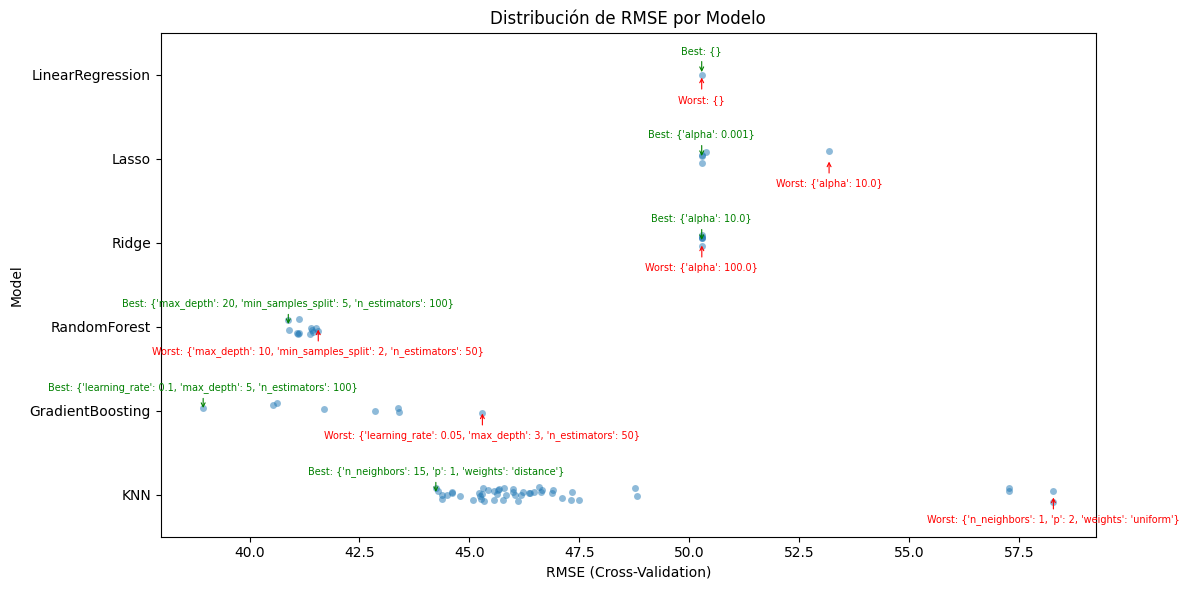

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,...,Model,param_alpha,param_max_depth,param_min_samples_split,param_n_estimators,param_learning_rate,param_n_neighbors,param_p,param_weights,rmse
0,0.003611,0.000489,0.001400,0.000489,{},-51.517680,-49.459501,-50.566093,-50.989237,-48.886994,...,LinearRegression,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.283901
1,0.005622,0.000376,0.002000,0.000632,{'alpha': 0.001},-51.517755,-49.459724,-50.566060,-50.989199,-48.886763,...,Lasso,0.001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.283900
2,0.006200,0.002481,0.001201,0.000402,{'alpha': 0.01},-51.518446,-49.461737,-50.565779,-50.988869,-48.884699,...,Lasso,0.010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.283906
3,0.004401,0.000493,0.001801,0.000398,{'alpha': 0.1},-51.526384,-49.482726,-50.563889,-50.986494,-48.865020,...,Lasso,0.100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.284903
4,0.003996,0.000626,0.001594,0.000495,{'alpha': 1.0},-51.699672,-49.759781,-50.629766,-51.020732,-48.752597,...,Lasso,1.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.372510
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,0.010800,0.000749,0.052206,0.003750,"{'n_neighbors': 35, 'p': 2, 'weights': 'distan...",-46.240156,-45.762262,-45.215019,-47.102503,-44.023648,...,KNN,NaN,NaN,NaN,NaN,NaN,35.0,2.0,distance,45.668718
75,0.010304,0.000402,0.077229,0.005766,"{'n_neighbors': 40, 'p': 1, 'weights': 'uniform'}",-47.736913,-46.446097,-45.796749,-47.633350,-44.714707,...,KNN,NaN,NaN,NaN,NaN,NaN,40.0,1.0,uniform,46.465563
76,0.011705,0.000608,0.082221,0.011385,"{'n_neighbors': 40, 'p': 1, 'weights': 'distan...",-45.342714,-44.840691,-44.479640,-46.033457,-43.221504,...,KNN,NaN,NaN,NaN,NaN,NaN,40.0,1.0,distance,44.783601
77,0.011804,0.000749,0.056312,0.001716,"{'n_neighbors': 40, 'p': 2, 'weights': 'uniform'}",-48.364208,-47.187004,-46.769705,-48.687091,-45.525635,...,KNN,NaN,NaN,NaN,NaN,NaN,40.0,2.0,uniform,47.306729


In [200]:
graficar_rmse_modelos([grid_results])

C:\Users\yosse\AppData\Local\Temp\ipykernel_8456\1614309977.py:157: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=best_rmse_df, x='rmse', y='Model', palette='viridis')


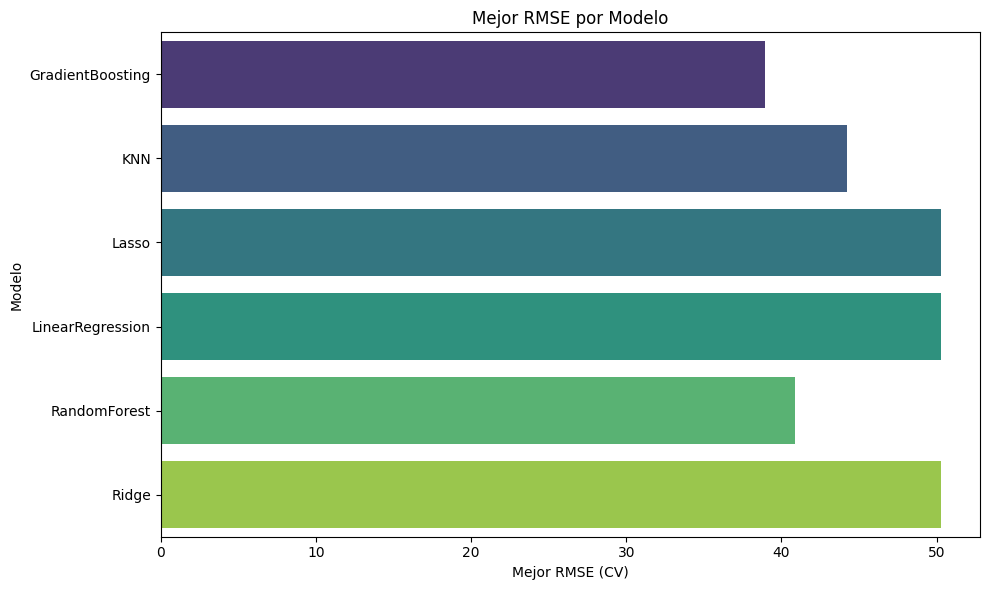

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,...,Model,param_alpha,param_max_depth,param_min_samples_split,param_n_estimators,param_learning_rate,param_n_neighbors,param_p,param_weights,rmse
30,0.950815,0.009387,0.004607,0.000592,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",-39.868341,-39.228750,-38.841787,-40.083905,-36.703054,...,GradientBoosting,NaN,5,NaN,100.0,0.1,NaN,NaN,NaN,38.945167
56,0.011796,0.001469,0.051519,0.006441,"{'n_neighbors': 15, 'p': 1, 'weights': 'distan...",-44.288796,-44.244694,-43.764499,-45.720110,-43.167954,...,KNN,NaN,NaN,NaN,NaN,NaN,15.0,1.0,distance,44.237211
1,0.005622,0.000376,0.002000,0.000632,{'alpha': 0.001},-51.517755,-49.459724,-50.566060,-50.989199,-48.886763,...,Lasso,0.001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.283900
0,0.003611,0.000489,0.001400,0.000489,{},-51.517680,-49.459501,-50.566093,-50.989237,-48.886994,...,LinearRegression,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.283901
22,1.832097,0.076265,0.029319,0.001326,"{'max_depth': 20, 'min_samples_split': 5, 'n_e...",-41.618707,-41.378578,-40.697655,-42.057584,-38.653858,...,RandomForest,NaN,20,5.0,100.0,NaN,NaN,NaN,NaN,40.881277
9,0.003203,0.000753,0.001001,0.000010,{'alpha': 10.0},-51.519698,-49.462944,-50.566581,-50.987721,-48.881984,...,Ridge,10.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.283786


In [201]:
graficar_mejor_rmse_por_modelo([grid_results])

3. Modelo de clasificación: Predecir si una orden será productiva o no
    - Identificar qué combinaciones de proceso/turno/usuario/duración/maquina generan alta eficiencia

In [202]:
# Definimos un umbral de eficiencia_piezas_por_min para "productivo"
umbral_eficiencia = 0.8  # ajusta según contexto
#Crear una copia del DataFrame original para evitar modificarlo directamente
df_cmodel = df_char.copy()
#df_cmodel['productiva'] = (df_cmodel['eficiencia_piezas_por_min'] >= umbral_eficiencia).astype(int)


In [203]:
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split

def preparar_datos_clasificacion(df, features, target_col, filtro=None, test_size=0.2, random_state=42):
    if filtro is not None:
        df = df.query(filtro).copy()
    X = df[list(features.keys())].copy()
    y = df[target_col].copy()

    cat_features = [f for f, t in features.items() if t == 'categorica']
    num_features = [f for f, t in features.items() if t == 'numerica']

    # Codificación ordinal
    encoder = OrdinalEncoder()
    if cat_features:
        X[cat_features] = encoder.fit_transform(X[cat_features])

    # Escalado numérico
    scaler = StandardScaler()
    if num_features:
        X[num_features] = scaler.fit_transform(X[num_features])

    # Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    return X_train, X_test, y_train, y_test, encoder, scaler

from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score,
    recall_score, f1_score, classification_report
)
import pandas as pd

def evaluar_modelos_clasificacion(models, X_train, y_train):


    tuned_results = {}
    all_grid_results = []

    for name, config in models.items():
        print(f"Evaluando: {name}")

        grid = GridSearchCV(
            estimator=config["model"],
            param_grid=config["params"],
            cv=5,
            scoring="roc_auc",   # Métrica principal para seleccionar el mejor
            n_jobs=-1
        )

        grid.fit(X_train, y_train)
        best_model = grid.best_estimator_

        # Probabilidades y predicciones con validación cruzada
        y_proba = cross_val_predict(best_model, X_train, y_train, cv=5, method='predict_proba')[:, 1]
        y_pred = cross_val_predict(best_model, X_train, y_train, cv=5)

        # Calcular métricas adicionales
        roc_auc = roc_auc_score(y_train, y_proba)
        accuracy = accuracy_score(y_train, y_pred)
        precision = precision_score(y_train, y_pred, zero_division=0)
        recall = recall_score(y_train, y_pred, zero_division=0)
        f1 = f1_score(y_train, y_pred, zero_division=0)

        print(f"ROC AUC: {roc_auc:.4f}")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")
        print("="*50)

        tuned_results[name] = {
            "Model": best_model,
            "Best Params": grid.best_params_,
            "ROC AUC": roc_auc,
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1 Score": f1
        }

        grid_df = pd.DataFrame(grid.cv_results_)
        grid_df["Model"] = name
        all_grid_results.append(grid_df)

    tuned_metrics = pd.DataFrame({
        model_name: {k: v for k, v in result.items() if k != "Model"}
        for model_name, result in tuned_results.items()
    }).T

    return tuned_results, tuned_metrics, all_grid_results
def graficar_metrica_roc_auc_por_modelo(all_grid_results):
    """
    Grafica la distribución de ROC AUC para cada modelo, anotando mejores y peores parámetros.

    Parámetros:
    - all_grid_results: lista de pd.DataFrame con resultados de GridSearchCV y columna 'Model'.

    Retorna:
    - cv_scores_df: DataFrame con resultados concatenados y columna 'roc_auc' (positiva).
    """
    # Concatenar resultados
    cv_scores_df = pd.concat(all_grid_results, ignore_index=True)

    # mean_test_score ya viene positivo para ROC AUC (mayor es mejor)
    cv_scores_df['roc_auc'] = cv_scores_df['mean_test_score']

    plt.figure(figsize=(12, 6))
    sns.stripplot(data=cv_scores_df, x='roc_auc', y='Model', jitter=True, alpha=0.5)
    plt.xlabel("ROC AUC (Cross-Validation)")
    plt.title("Distribución de ROC AUC por Modelo")

    # Anotar mejores y peores hiperparámetros por modelo
    for model in cv_scores_df["Model"].unique():

        df_model = cv_scores_df[cv_scores_df["Model"] == model]
        best_row = df_model.loc[df_model["roc_auc"].idxmax()]  # Max ROC AUC
        worst_row = df_model.loc[df_model["roc_auc"].idxmin()]

        # Anotación Best
        plt.annotate(
            f"Best: {best_row['params']}",
            xy=(best_row['roc_auc'], model),
            textcoords='offset points',
            xytext=(0, 15),
            ha='center',
            fontsize=7,
            color='green',
            arrowprops=dict(arrowstyle="->", color='green', lw=0.8)
        )

        # Anotación Worst
        plt.annotate(
            f"Worst: {worst_row['params']}",
            xy=(worst_row['roc_auc'], model),
            textcoords='offset points',
            xytext=(0, -20),
            ha='center',
            fontsize=7,
            color='red',
            arrowprops=dict(arrowstyle="->", color='red', lw=0.8)
        )

    plt.tight_layout()
    plt.show()

    return cv_scores_df
def graficar_mejor_roc_auc_por_modelo(all_grid_results):
    """
    Grafica la mejor ROC AUC (máxima) obtenida por cada modelo.

    Parámetros:
    - all_grid_results: lista de pd.DataFrame con resultados de GridSearchCV y columna 'Model'.

    Retorna:
    - best_roc_auc_df: DataFrame con la mejor ROC AUC por modelo.
    """
    cv_scores_df = pd.concat(all_grid_results, ignore_index=True)
    cv_scores_df['roc_auc'] = cv_scores_df['mean_test_score']

    # Obtener índices de máximos ROC AUC por modelo
    idx_best = cv_scores_df.groupby('Model')['roc_auc'].idxmax()
    best_roc_auc_df = cv_scores_df.loc[idx_best].copy()

    plt.figure(figsize=(10, 6))
    sns.barplot(data=best_roc_auc_df, x='roc_auc', y='Model', palette='viridis')
    plt.xlabel("Mejor ROC AUC (CV)")
    plt.ylabel("Modelo")
    plt.title("Mejor ROC AUC por Modelo")
    plt.tight_layout()
    plt.show()

    return best_roc_auc_df


In [204]:
features = {
    'turno': 'categorica',
    'usuario': 'categorica',
    'duracion_min': 'numerica',
    'fabricadas': 'numerica',
    'maquina': 'categorica'
}
X_train, X_test, y_train, y_test, encoder, scaler = preparar_datos_clasificacion(
    df_cmodel, features, target_col='productiva', filtro='estado == "play"'
)

KeyError: 'productiva'

In [ ]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier

models = {
    "RandomForest": {
        "model": RandomForestClassifier(random_state=42),
        "params": {
            "n_estimators": [50, 100],
            "max_depth": [5, 10, None],
            "min_samples_split": [2, 5]
        }
    },
    "LogisticRegression": {
        "model": LogisticRegression(max_iter=1000, solver='liblinear'),
        "params": {
            "C": [0.1, 1, 10],
            "penalty": ['l1', 'l2']
        }
    },
    "GradientBoosting": {
        "model": GradientBoostingClassifier(random_state=42),
        "params": {
            "n_estimators": [50, 100],
            "learning_rate": [0.01, 0.1],
            "max_depth": [3, 5]
        }
    },
    "KNN": {
        "model": KNeighborsClassifier(),
        "params": {
            "n_neighbors": [3, 5, 7],
            "weights": ['uniform', 'distance']
        }
    },
    "NaiveBayes": {
        "model": GaussianNB(),
        "params": {
            # No hyperparameters to tune in GaussianNB
        }
    }
}


In [ ]:
# Evaluar modelos
tuned_results, tuned_metrics, grid_results = evaluar_modelos_clasificacion(models, X_train, y_train)

print(tuned_metrics.sort_values(by='F1 Score', ascending=False))

Evaluando: RandomForest
ROC AUC: 0.9091
Accuracy: 0.9942
Precision: 0.9942
Recall: 1.0000
F1 Score: 0.9971
Evaluando: LogisticRegression
ROC AUC: 0.6666
Accuracy: 0.9942
Precision: 0.9942
Recall: 1.0000
F1 Score: 0.9971
Evaluando: GradientBoosting
ROC AUC: 0.8719
Accuracy: 0.9941
Precision: 0.9942
Recall: 0.9999
F1 Score: 0.9970
Evaluando: SVM


KeyboardInterrupt: 

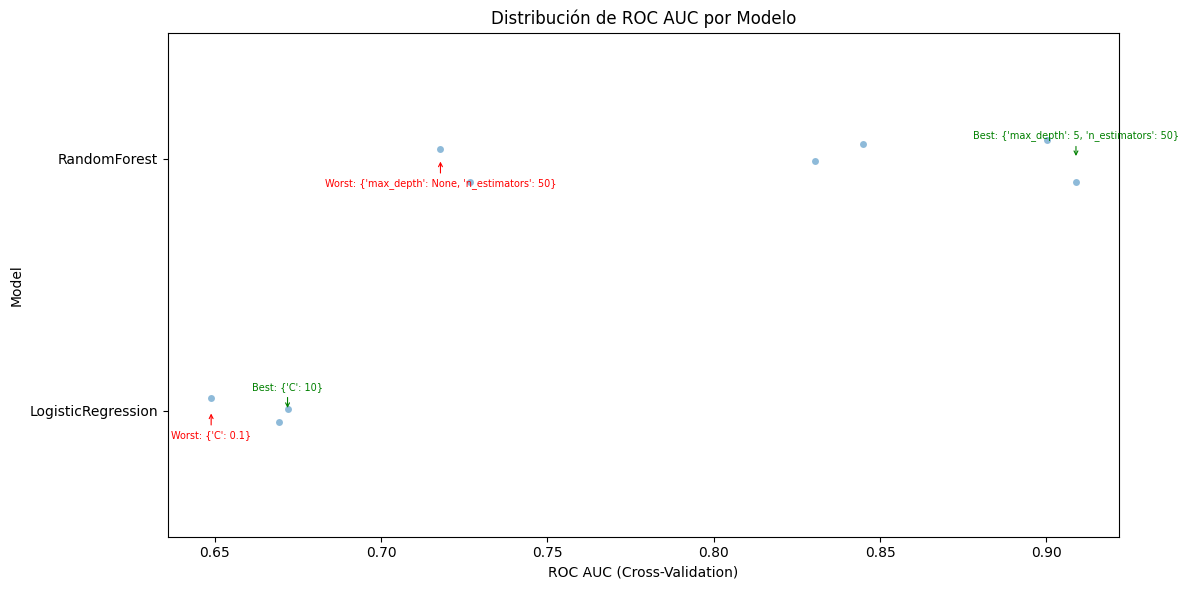

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,Model,param_C,roc_auc
0,0.299257,0.081373,0.020751,0.009102,5,50.0,"{'max_depth': 5, 'n_estimators': 50}",0.871425,0.858005,0.955702,0.917003,0.942240,0.908875,0.038373,1,RandomForest,NaN,0.908875
1,0.602479,0.107796,0.022218,0.002672,5,100.0,"{'max_depth': 5, 'n_estimators': 100}",0.814868,0.860188,0.958488,0.922416,0.944470,0.900086,0.054283,2,RandomForest,NaN,0.900086
2,0.311272,0.120294,0.016007,0.002102,10,50.0,"{'max_depth': 10, 'n_estimators': 50}",0.672688,0.837760,0.925566,0.785608,0.929972,0.830319,0.095817,4,RandomForest,NaN,0.830319
3,0.534863,0.072003,0.026823,0.006460,10,100.0,"{'max_depth': 10, 'n_estimators': 100}",0.648078,0.834556,0.939450,0.859531,0.941961,0.844715,0.107164,3,RandomForest,NaN,0.844715
4,0.264705,0.051525,0.014799,0.001472,None,50.0,"{'max_depth': None, 'n_estimators': 50}",0.600483,0.728594,0.845700,0.689450,0.724907,0.717827,0.078857,6,RandomForest,NaN,0.717827
5,0.583944,0.044154,0.014910,0.001913,None,100.0,"{'max_depth': None, 'n_estimators': 100}",0.593936,0.724786,0.837389,0.756050,0.721794,0.726791,0.078444,5,RandomForest,NaN,0.726791
6,0.024035,0.004322,0.006501,0.000899,NaN,NaN,{'C': 0.1},0.668648,0.582467,0.759844,0.622798,0.610688,0.648889,0.062054,3,LogisticRegression,0.1,0.648889
7,0.032553,0.002894,0.006196,0.000980,NaN,NaN,{'C': 1},0.704773,0.611534,0.788819,0.619295,0.622212,0.669327,0.068699,2,LogisticRegression,1.0,0.669327
8,0.026712,0.003877,0.003397,0.000801,NaN,NaN,{'C': 10},0.703938,0.620914,0.792441,0.620144,0.621840,0.671855,0.068324,1,LogisticRegression,10.0,0.671855


In [ ]:
graficar_metrica_roc_auc_por_modelo(grid_results)


C:\Users\yosse\AppData\Local\Temp\ipykernel_8456\2284315304.py:167: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=best_roc_auc_df, x='roc_auc', y='Model', palette='viridis')


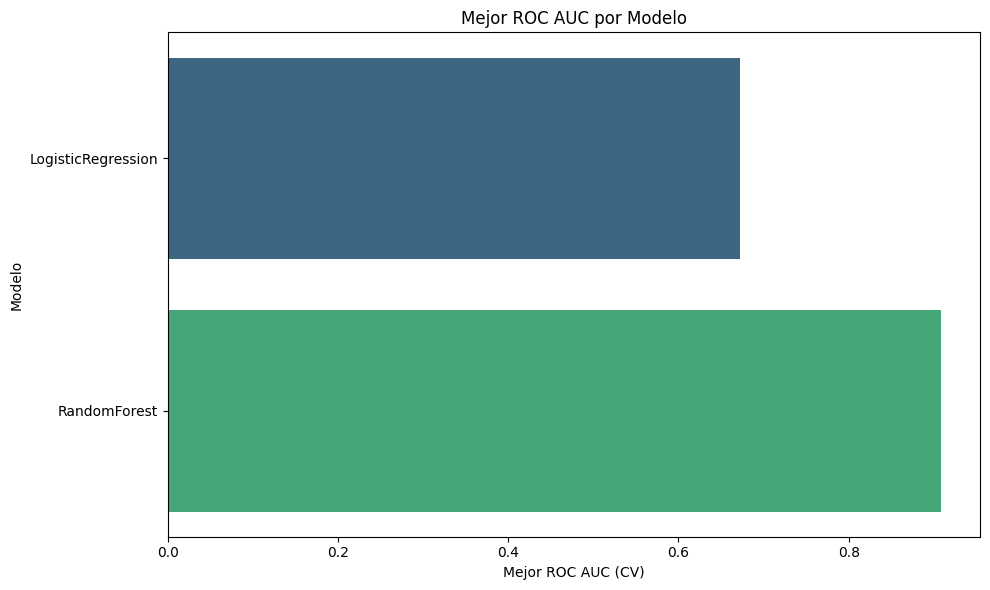

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,Model,param_C,roc_auc
8,0.026712,0.003877,0.003397,0.000801,NaN,NaN,{'C': 10},0.703938,0.620914,0.792441,0.620144,0.62184,0.671855,0.068324,1,LogisticRegression,10.0,0.671855
0,0.299257,0.081373,0.020751,0.009102,5,50.0,"{'max_depth': 5, 'n_estimators': 50}",0.871425,0.858005,0.955702,0.917003,0.94224,0.908875,0.038373,1,RandomForest,NaN,0.908875


In [ ]:
graficar_mejor_roc_auc_por_modelo(grid_results)